In [ ]:
%load_ext autoreload
%autoreload 2

# ─── Core --------------------------------------------------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ─── DeepSynergy package -----------------------------------------------------
from deepsynergy import (
    DeepSynergy,
    decoders,
    encoders,
)
from deepsynergy.utils_training import (
    train_decoder,
    train_deepsynergy_model,
    relax_deepsynergy_model,
    ParameterScheduler,
)

# ─── Data helper -------------------------------------------------------------
from deepsynergy.utils_data import gate_AND    # AND, XOR, UNQ, RDN available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DeepSynergy on logical gates

We reproduce the AND gate experiment from the paper and validate three
quantities:

1. $H(Y \mid X_1,X_2)$ — via a **decoder** $q(y\mid x_1,x_2)$  
2. $H(X_i \mid Y)$    — via a **decoder** $q(x_i\mid y)$, $i=1,2$  
3. $\max_Z H(Y \mid Z)$ subject to the Blackwell constraint, via the
   adversarial **DeepSynergy** model.

Synergy is finally
$$S = \max_Z H(Y\!\mid\!Z) - H(Y\!\mid\!X_1,X_2).$$

In [2]:
# Logical gate (switch to gate_XOR(), gate_UNQ(), gate_RDN() if desired)
X, Y = gate_AND()                       # tensors of shape (4, 2) and (4, 1)

print("Truth table:")
print(torch.cat((X, Y), dim=1))

Truth table:
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 1., 1.]])


## 1 · Decoder for $H(Y\mid X_1,X_2)$

For a deterministic gate this entropy is **zero**; we train a binary
decoder to check the implementation.

100%|██████████| 2000/2000 [00:12<00:00, 164.09it/s, loss=[7.0278336e-05]]


Estimated H(Y|X₁,X₂): 0.000 bits  (theory: 0 bits)


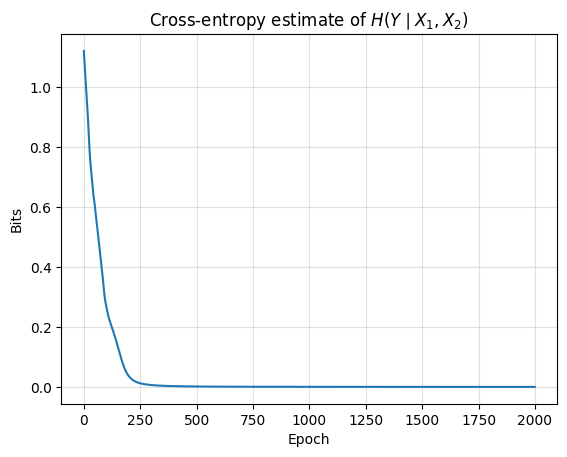

In [12]:
# Parameters
batch_size = 4   # one full truth-table batch
epochs      = 2_000

# DataLoader
dataloader = DataLoader(TensorDataset(X, Y), batch_size=batch_size)

# Decoder q(y | x₁,x₂)
decoder_y_x = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(2, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 1),
    )
).to(device)

optim = torch.optim.Adam(decoder_y_x.parameters(), lr=1e-2)

results_y_x = train_decoder(
    model         = decoder_y_x,
    dataloader    = dataloader,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

plt.figure()
plt.plot(results_y_x["loss_history"], color="tab:blue")
plt.title("Cross-entropy estimate of $H(Y\\mid X_1,X_2)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

H_y_x = results_y_x["loss"][0]
print(f"Estimated H(Y|X₁,X₂): {H_y_x:.3f} bits  (theory: 0 bits)")

## 2 · Decoder for $H(X_i\mid Y)$  (lower bound for the constraint)

The AND gate gives the analytic value  
$H(X_i\mid Y) = \tfrac34\log_2 3 - \tfrac12 \approx 0.688$ bits.


100%|██████████| 2000/2000 [00:10<00:00, 196.55it/s, loss=[0.68873096 0.6887292 ]]


Estimated H(X₁|Y): 0.689 bits (theory: 0.689)
Estimated H(X₂|Y): 0.689 bits (theory: 0.689)


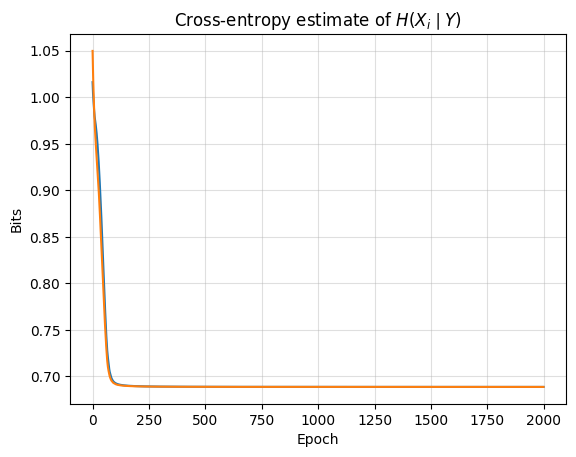

In [8]:
# Parameters
batch_size = 4
epochs      = 2_000
H_theory_Xi = 0.75 * np.log2(3) - 0.5    # ≈ 0.688

# DataLoader (swap roles: predictor = Y, target = X)
loader = DataLoader(TensorDataset(Y, X), batch_size=batch_size)

# One decoder predicts both x₁ and x₂
decoder_x_y = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(1, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 2),            # two logits
    )
).to(device)

optim = torch.optim.Adam(decoder_x_y.parameters(), lr=1e-2)

results_x_y = train_decoder(
    model         = decoder_x_y,
    dataloader    = loader,
    optimizer     = optim,
    show_progress = True,
    device        = device,
    epochs        = epochs,
)

plt.figure()
plt.plot(results_x_y["loss_history"])
plt.title("Cross-entropy estimate of $H(X_i\\mid Y)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

H_xi_y = results_x_y["loss"]            # vector (2,)
print(f"Estimated H(X₁|Y): {H_xi_y[0]:.3f} bits (theory: {H_theory_Xi:.3f})")
print(f"Estimated H(X₂|Y): {H_xi_y[1]:.3f} bits (theory: {H_theory_Xi:.3f})")

## 3 · DeepSynergy data loader

We *duplicate* each $(x,y)$ row 128 times before building the
`DataLoader`.

*Purpose*: give the GPU more samples per batch so the network trains
faster and more stably.  
The stochastic encoder inside DeepSynergy **still** draws multiple
$z$’s *per duplicate*, so we end up with many independent estimates of
$q(x\mid y)$ for the *same* symbol — effectively a larger Monte-Carlo
set for every optimisation step.

In [3]:
# Duplicate each truth-table line 128×
X_rep = X.repeat_interleave(128, dim=0)
Y_rep = Y.repeat_interleave(128, dim=0)

# Full dataset fits in one batch → maximal GPU parallelism
loader_ds = DataLoader(TensorDataset(X_rep, Y_rep), batch_size=512)

In [7]:
latent_dim = 2  # 2-D latent Z

encoder = encoders.GaussianEncoder(
    nn.Sequential(
        nn.Linear(1, 8), nn.ReLU(),
        nn.Linear(8, 16), nn.ReLU(),
    ),
    latent_dim=latent_dim,
    layers_post=nn.Sequential(
        nn.Linear(latent_dim, 8), nn.ReLU(),
        nn.Linear(8, latent_dim),
    )
)

disc_y = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 1),
    )
)

gen_x = decoders.BinaryDecoder(
    nn.Sequential(
        nn.Linear(latent_dim, 4), nn.ReLU(),
        nn.Linear(4, 8), nn.ReLU(),
        nn.Linear(8, 2),
    )
)

model = DeepSynergy(
    q_z_given_y = encoder,
    q_y_given_z = disc_y,
    q_x_given_z = gen_x,
    num_z_samples = 200,
    optimizer   = (torch.optim.Adam, torch.optim.Adam),
    lr          = (1e-2, 1e-2),
).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:01<00:00, 16.22it/s, beta=30, loss_y=[0.49972615], loss_x=[0.6952815 0.6901717]]   


Text(0, 0.5, 'Bits')

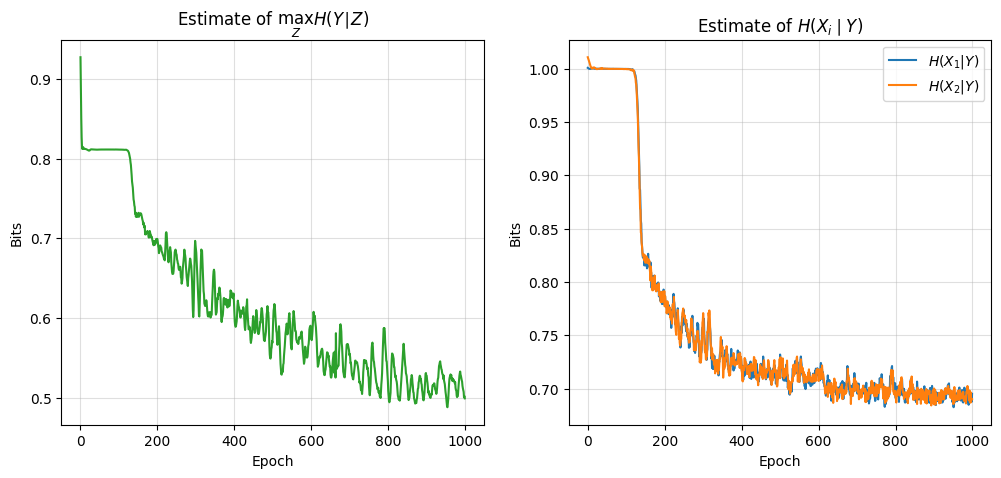

In [8]:
beta_scheduler = ParameterScheduler(
    value_min = 1,
    value_max = 30,
    epochs_num = 1_000,
    method = "linear",
)

train_results = train_deepsynergy_model(
    model           = model,
    dataloader      = loader_ds,
    beta            = beta_scheduler,
    alpha           = 5,
    n_critic        = 5,
    epochs          = 1_000,
    device          = device,
)

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_results["loss_y_history"], color="tab:green")
plt.title("Estimate of $\\max_Z H(Y\\mid Z)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

plt.subplot(1, 2, 2)
plt.plot(train_results["loss_x_history"][:, 0], label="$H(X_1|Y)$")
plt.plot(train_results["loss_x_history"][:, 1], label="$H(X_2|Y)$")
plt.legend(); plt.grid(alpha=0.4)
plt.title("Estimate of $H(X_i\\mid Y)$")
plt.xlabel("Epoch"); plt.ylabel("Bits")

  0%|          | 0/500 [00:00<?, ?it/s, loss_y=[0.5021294]]

100%|██████████| 500/500 [00:07<00:00, 70.21it/s, loss_y=[0.50164795]]


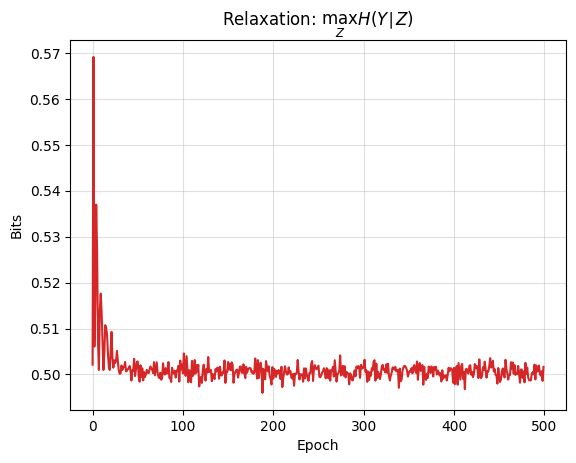

In [10]:
# Reset optimiser state, then run discriminator-only relaxation
model.reset_optimizers(optimizer="Adam", lr=1e-2)

relax_results = relax_deepsynergy_model(
    model         = model,
    dataloader    = loader_ds,
    epochs        = 500,
    device        = device,
)

plt.figure()
plt.plot(relax_results["loss_y_history"], color="tab:red")
plt.title("Relaxation: $\\max_Z H(Y\\mid Z)$")
plt.xlabel("Epoch"); plt.ylabel("Bits"); plt.grid(alpha=0.4)

In [16]:
H_y_z    = relax_results["loss_y"][0]
H_y_x12  = results_y_x["loss"][0]          # scalar (deterministic gate → ~0)
synergy  = H_y_z - H_y_x12

print(f"Synergy (AND gate): {synergy:.4f} bits")

Synergy (AND gate): 0.5016 bits
